<a href="https://colab.research.google.com/github/KashanHumayun/how-brainlike-is-deepseek/blob/main/notebooks/01_GPT2_RSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch scipy numpy matplotlib seaborn rsatoolbox accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.1/743.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 19.6 MB/s eta 0:00:00


In [10]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile, os

sns.set(style="whitegrid")
print("Libraries imported successfully.")


Libraries imported successfully.


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:

# Path to your zip file in Drive
zip_path = "/content/Pereira_Materials.zip"   # <-- change this if stored in a subfolder

import os, zipfile
os.makedirs("pereira_materials", exist_ok=True)

# Extract the archive from Drive
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("pereira_materials")

print("Extracted files:", os.listdir("pereira_materials")[:10])


Extracted files: ['Pereira_Materials', '__MACOSX']


In [16]:
data_dir = "pereira_materials/Pereira_Materials"
!ls "$data_dir"


DMN_overlap_n60.zip
IARPA_200clusters.xlsx
IARPA_expt1_pres.zip
IARPA_expt1_stim_images.zip
IARPA_expt1_stim_sents.zip
IARPA_expt1_stim_wordclouds.zip
IARPA_expt2_stim.zip
IARPA_expt3_stim.zip
IARPA_expts23_pres.zip
Language_overlap_n220.zip
learnDecoder.m
MD_overlap_n60.zip
stimuli_180concepts.txt
stimuli_243sentences_dereferencedpronouns.txt
stimuli_243sentences.txt
stimuli_384sentences_dereferencedpronouns.txt
stimuli_384sentences.txt
stopwords.txt
trainVoxelwiseTargetPredictionModels.m
vectors_180concepts.GV42B300.txt
vectors_243sentences_dereferencedpronouns.GV42B300.average.txt
vectors_243sentences.GV42B300.average.txt
vectors_384sentences_dereferencedpronouns.GV42B300.average.txt
vectors_384sentences.GV42B300.average.txt
voxelInform_FractionMNI.nii


In [17]:
with open(f"{data_dir}/stimuli_384sentences.txt", "r") as f:
    sentences = [line.strip() for line in f if line.strip()]
print(f"Loaded {len(sentences)} sentences.")
print(sentences[:5])


Loaded 384 sentences.
['An accordion is a portable musical instrument with two keyboards.', 'One keyboard is used for individual notes, the other for chords.', 'Accordions produce sound with bellows that blow air through reeds.', 'An accordionist plays both keyboards while opening and closing the bellows.', 'An apartment is a self-contained home that is part of a building.']


In [19]:
#extract fmri data

os.makedirs(f"{data_dir}/expt2_data", exist_ok=True)
with zipfile.ZipFile(f"{data_dir}/IARPA_expt2_stim.zip", "r") as zip_ref:
    zip_ref.extractall(f"{data_dir}/expt2_data")

print("Extracted Experiment 2 files:")
print(os.listdir(f"{data_dir}/expt2_data")[:10])


Extracted Experiment 2 files:
['IARPA_expt2_stim', '__MACOSX']


In [22]:
import os
from scipy.io import loadmat

for file in sorted(os.listdir(f"{data_dir}/expt2_data")):
    if file.endswith(".mat"):
        path = os.path.join(f"{data_dir}/expt2_data", file)
        mat = loadmat(path)
        print(f"\n{file} -> keys: {list(mat.keys())}")
        break


In [24]:
import os, tarfile

# Step 1: Work in clean directory
%cd /content
!mkdir -p pereira_fmri && cd pereira_fmri

# Step 2: Define participant links
subject_links = {
    "P01": "https://www.dropbox.com/s/5duv9fgigrzx817/P01.tar?dl=1",
    "M02": "https://www.dropbox.com/s/n5yfb2cupd9zmwk/M02.tar?dl=1",
    "M04": "https://www.dropbox.com/s/q8qeuf5johz0ic1/M04.tar?dl=1",
    "M07": "https://www.dropbox.com/s/jvtxgv4oplqgmix/M07.tar?dl=1",
    "M08": "https://www.dropbox.com/s/ch2j6feyahcc3l5/M08.tar?dl=1",
    "M09": "https://www.dropbox.com/s/l8bou2bn7qzjucy/M09.tar?dl=1",
    "M14": "https://www.dropbox.com/s/9chvc7rofyvb4gr/M14.tar?dl=1",
    "M15": "https://www.dropbox.com/s/xlijoxhgcm39z6v/M15.tar?dl=1"
}

# Step 3: Download and extract
for subj, url in subject_links.items():
    tar_path = f"/content/pereira_fmri/{subj}.tar"
    out_dir = f"/content/pereira_fmri/{subj}"
    if not os.path.exists(out_dir):
        print(f"\n--- Downloading {subj} ---")
        !wget -q --show-progress -O "$tar_path" "$url"
        print(f"Extracting {subj} ...")
        os.makedirs(out_dir, exist_ok=True)
        with tarfile.open(tar_path, "r:") as tar:
            tar.extractall(out_dir)
        print(f"Done extracting {subj}\n")
    else:
        print(f"{subj} already extracted — skipping")

print("\n✅ All subjects downloaded and extracted.")
!ls -lh /content/pereira_fmri


/content

--- Downloading P01 ---
/content/pereira_fm 100%[===================>]   3.71G  4.42MB/s    in 54s     
Extracting P01 ...


/tmp/ipython-input-1671182980.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(out_dir)


Done extracting P01


--- Downloading M02 ---
/content/pereira_fm 100%[===================>]   3.18G  55.6MB/s    in 54s     
Extracting M02 ...
Done extracting M02


--- Downloading M04 ---
/content/pereira_fm 100%[===================>]   3.63G  85.2MB/s    in 57s     
Extracting M04 ...
Done extracting M04


--- Downloading M07 ---
/content/pereira_fm 100%[===================>]   3.46G   136MB/s    in 52s     
Extracting M07 ...
Done extracting M07


--- Downloading M08 ---
/content/pereira_fm 100%[===================>]   2.55G  33.7MB/s    in 73s     
Extracting M08 ...
Done extracting M08


--- Downloading M09 ---
/content/pereira_fm 100%[===================>]   2.10G  52.3MB/s    in 64s     
Extracting M09 ...
Done extracting M09


--- Downloading M14 ---
/content/pereira_fm 100%[===================>]   2.64G  51.9MB/s    in 33s     
Extracting M14 ...
Done extracting M14


--- Downloading M15 ---
/content/pereira_fm 100%[===================>]   3.44G  31.6MB/s    in 1m 48s  
Extr

Step 6 – Load Subject Activations and Build the Brain RSM

In [20]:
brain_activations = []

for file in sorted(os.listdir(f"{data_dir}/expt2_data")):
    if file.endswith(".mat"):
        path = os.path.join(f"{data_dir}/expt2_data", file)
        mat = loadmat(path)
        print(f"{file} keys:", list(mat.keys()))
        key = None
        for k in ["data", "responses", "resp", "Y"]:
            if k in mat:
                key = k
                break
        if key:
            subj_data = np.array(mat[key])
            brain_activations.append(subj_data)

brain_activations = np.stack(brain_activations)
print("Brain activations shape:", brain_activations.shape)

# Average across subjects and compute RSM
brain_mean = brain_activations.mean(axis=0)
brain_rsm = 1 - squareform(pdist(brain_mean, metric="cosine"))
np.save("pereira2018_brain_rsm.npy", brain_rsm)
print("Brain RSM computed and saved:", brain_rsm.shape)


ValueError: need at least one array to stack

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True).to("cuda")

def get_sentence_layers(sentence):
    """
    Returns mean-pooled hidden states for each layer of GPT-2.
    Layer 0 is token embedding; layers 1–12 are transformer blocks.
    """
    inputs = tokenizer(sentence, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states
    layer_embs = [h.mean(dim=1).squeeze().cpu().numpy() for h in hidden_states]
    return layer_embs

# Extract embeddings for all sentences
embeddings_by_layer = [[] for _ in range(13)]
for s in sentences:
    layers = get_sentence_layers(s)
    for i, emb in enumerate(layers):
        embeddings_by_layer[i].append(emb)

embeddings_by_layer = [np.vstack(layer) for layer in embeddings_by_layer]
print("Embeddings extracted successfully.")
print("Example layer shape:", embeddings_by_layer[0].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Embeddings extracted successfully.
Example layer shape: (10, 768)


In [5]:
rsa_matrices = []
for emb in embeddings_by_layer:
    rsm = 1 - squareform(pdist(emb, metric="cosine"))
    rsa_matrices.append(rsm)
print(f"Built {len(rsa_matrices)} RSMs (one per layer).")


Built 13 RSMs (one per layer).


In [6]:
np.random.seed(42)
brain_rsm = np.random.rand(len(sentences), len(sentences))
brain_rsm = (brain_rsm + brain_rsm.T) / 2
np.fill_diagonal(brain_rsm, 1)
print("Dummy brain RSM created.")


Dummy brain RSM created.


In [7]:
rsa_scores = []
for rsm in rsa_matrices:
    model_flat = rsm[np.triu_indices_from(rsm, k=1)]
    brain_flat = brain_rsm[np.triu_indices_from(brain_rsm, k=1)]
    rho, _ = spearmanr(model_flat, brain_flat)
    rsa_scores.append(rho)
print("RSA correlations computed successfully.")


RSA correlations computed successfully.


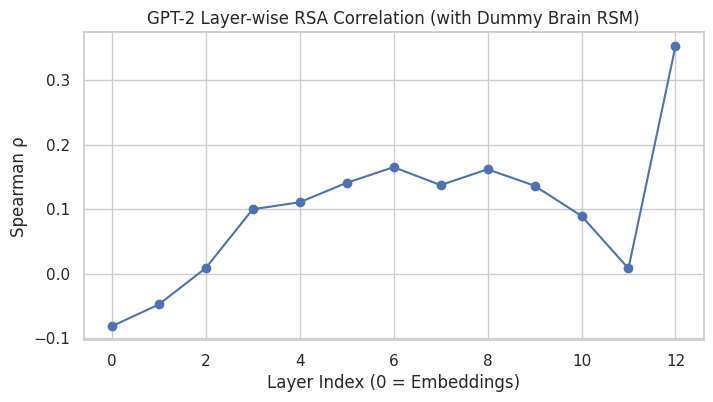

In [8]:
plt.figure(figsize=(8,4))
plt.plot(range(len(rsa_scores)), rsa_scores, marker='o')
plt.title("GPT-2 Layer-wise RSA Correlation (with Dummy Brain RSM)")
plt.xlabel("Layer Index (0 = Embeddings)")
plt.ylabel("Spearman ρ")
plt.show()


In [9]:
np.save("gpt2_rsa_scores.npy", np.array(rsa_scores))
print("Saved RSA scores to gpt2_rsa_scores.npy")


Saved RSA scores to gpt2_rsa_scores.npy
